In [1]:
# pip install xgboost
# %pip install graphviz

In [2]:
from xgboost import XGBRegressor
import pandas as pd 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Importing excel sheets as dfs, should both have samples in the same order
predictors_df = pd.read_excel('../Predictors_Cleaned.xlsx', 0)
    # Rows are samples, columns are predictors
outcomes_df = pd.read_excel('../Outcomes_Cleaned.xlsx', 0)
    # Rows are samples, columns are mechanisms

# Dropping unnecessary metadata
X = predictors_df.drop('SAMPLE NAME', axis=1)
Y = outcomes_df.drop('MECHANISM', axis=1) # Full DF must iterate through
feature_names = X.columns
gene_names = Y.columns

# List of columns for iterating
columns = list(Y)


# print(predictors_df) # 211 x 33
# print(outcomes_df) # 211 x 41

In [3]:
r2_list = []

for i in columns:
    
    # resetting the r2 and best model value for each column
    r2 = 0
    best_model = XGBRegressor()
    
    # Iterate through common proportions of test/train data
    for j in [0.2, 0.4, 0.6, 0.8]:

        # Split Data
        x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=j) 

        # Iterate through common n_estimators
        for k in [100, 500, 1000]:

            # Create model
            xg = XGBRegressor(n_estimators=k) 
            xg = xg.fit(x_train, y_train)

            # Find model r squared
            predictions = xg.predict(x_test)
            new_r2 = abs(r2_score(y_test, predictions)) # using absolute value for comparision

            # Compare model, if model r2 is over 1 then its very bad fit so we don't save it
            if new_r2 <= 1:
                if new_r2 > r2:
                    r2 = new_r2
                    # Saving the better model
                    best_model = xg
                    # Saving best model params for visualization
                    best_x_test = x_test
                    best_y_test = y_test
    
    # Storing highest r2
    r2_list.append(r2)
    # Printing r2
    print(f"{i} r2: {r2}")
    
    if r2 != 0: # if a best model exists
        # Finally dumping the best model for the class
        joblib.dump(best_model, f"Models/xgb_{i}.joblib")
    
        # Visualizing Tree
        plt.figure()  
        plot_tree(best_model) 
        plt.gcf().set_size_inches(60, 40)
        plt.savefig(f'Trees/{i}_tree.png')
        plt.close()
    
        # Visualizing feature importance
        perm_importance = permutation_importance(best_model, best_x_test, best_y_test)
        sorted_idx = perm_importance.importances_mean.argsort()
        plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.gcf().set_size_inches(10, 7)
        plt.xlabel(f"{i} Permutation Importance")
        plt.savefig(f'Features/{i}_features.png')
        plt.close()

Lipopeptides r2: 0.2390040159225464
Arsenic_resistance r2: 0.2898220419883728
Copper_resistance r2: 0.8268964290618896
Rifampin r2: 0.789775013923645
Trimethoprim r2: 0.8521906137466431
Tellurim_resistance r2: 0.5931044816970825
Zinc_resistance r2: 0.3738056421279907
Peroxide_resistance r2: 0.1834089756011963
Multi-drug_resistance r2: 0.1685255765914917
Acid_resistance r2: 0.49058103561401367
Phenolic_compound_resistance r2: 0.7687035799026489
Mupirocin r2: 0.012345671653747559
Nucleosides r2: 0.5321741104125977
Aldehyde_resistance r2: 0.7823930978775024
Paraquat_resistance r2: 0.42549335956573486
Betalactams r2: 0.3474797010421753
Tetracyclines r2: 0.477774977684021
Nickel_resistance r2: 0.47649991512298584
Multibiocide_resistance r2: 0.20350563526153564
Aminoglycoside r2: 0.3978360891342163
MLS r2: 0.23498117923736572
Fluoroquinolones r2: 0.6088637113571167
Fosfomycin r2: 0.8069260120391846
Phenicol_resistance r2: 0.865363597869873
Drug_and_biocide_resistance r2: 0.38317179679870605


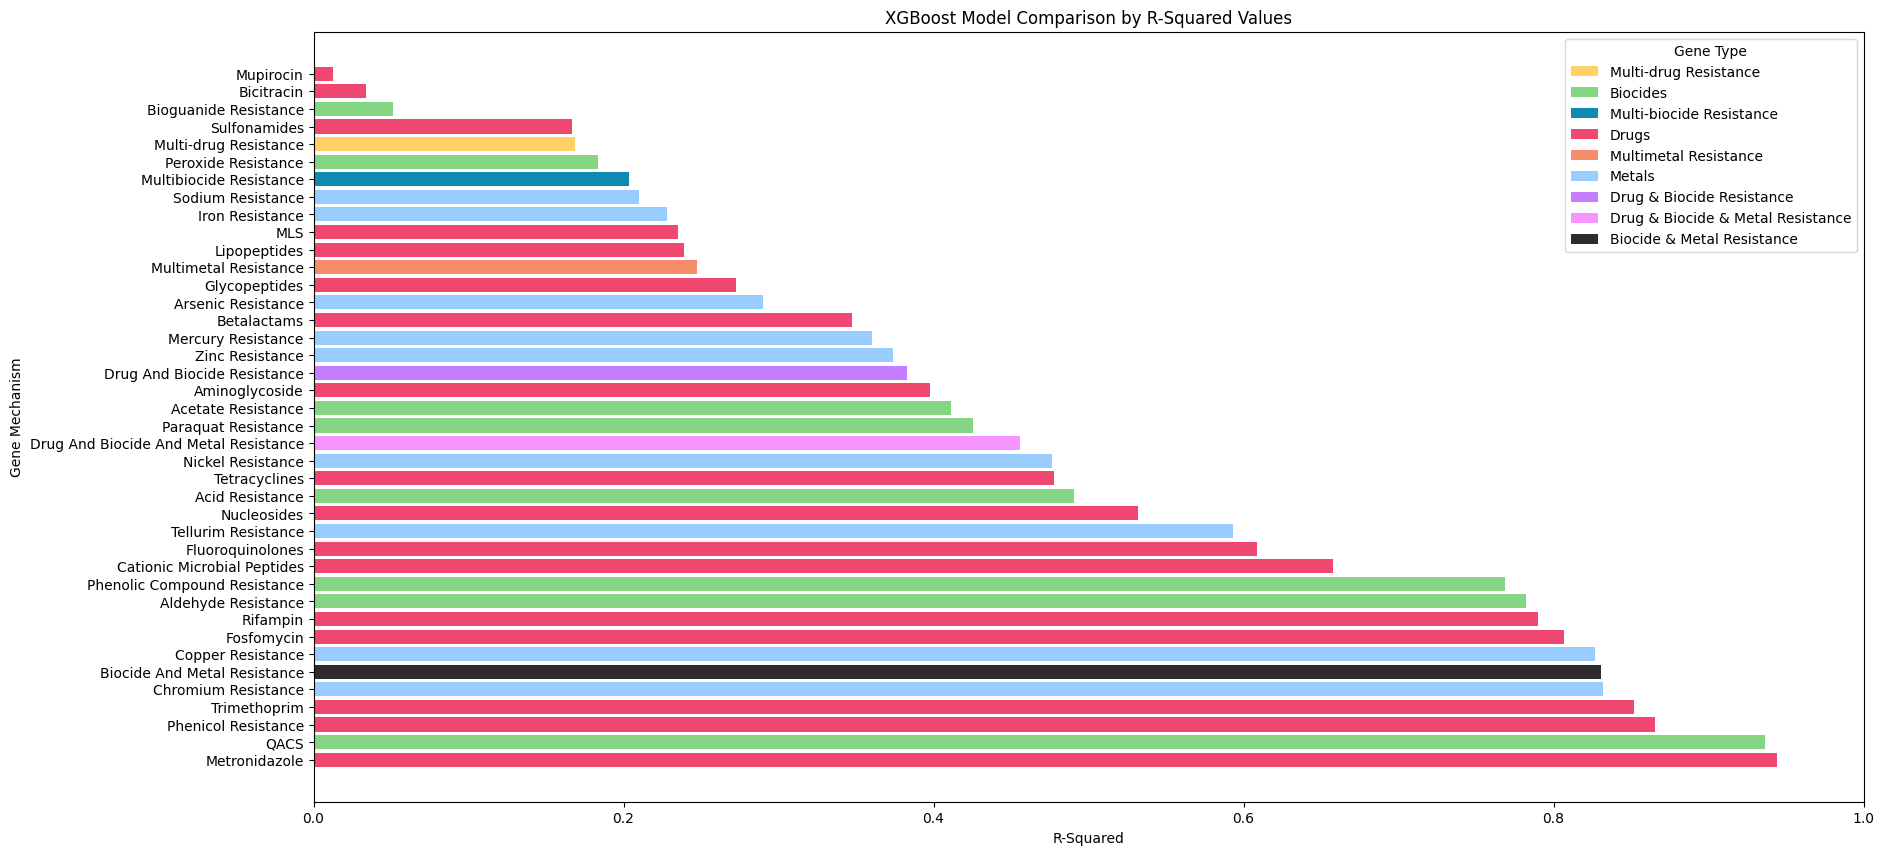

Figure 1: XGBoost model comparison for 40 gene mechanism frequency prediction models. Models are compared via the absolute values of their r-squared values displayed on the x-axis and sorted from least to greatest. The Y-axis labels the gene mechanisms that each model is predicting the frequency of. Models are additionally color-coded by gene type, which is displayed in the legend.


In [4]:
# Plotting an overall comparision of different models and their r2 scores
# Order and compare the accuracy of models depending on drug/metal/biociode/multicompound types etc
import numpy as np

fig, ax = plt.subplots(figsize=(20,10))

# Sorting r2 values for visualization
sorted_idx = np.argsort(r2_list)
r2_array = np.array(r2_list)

# Sorting colors for visualization
bar_labels = ['Drugs', 'Metals', '_Metals', '_Drugs', '_Drugs', '_Metals', '_Metals', 'Biocides', 'Multi-drug Resistance', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Metals', 'Multi-biocide Resistance', '_Drugs', '_Drugs', '_Drugs', '_Drugs', '_Drugs', 'Drug & Biocide Resistance', 'Multimetal Resistance', '_Metals', '_Drugs', '_Drugs', 'Drug & Biocide & Metal Resistance', '_Drugs', 'Biocide & Metal Resistance', '_Metals', '_Biocides', '_Drugs', '_Biocides', '_Drugs', '_Metals', '_Metals', '_Biocides']
formatted_genes = ['Lipopeptides', 'Arsenic Resistance', 'Copper Resistance', 'Rifampin',
       'Trimethoprim', 'Tellurim Resistance', 'Zinc Resistance',
       'Peroxide Resistance', 'Multi-drug Resistance', 'Acid Resistance',
       'Phenolic Compound Resistance', 'Mupirocin', 'Nucleosides',
       'Aldehyde Resistance', 'Paraquat Resistance', 'Betalactams',
       'Tetracyclines', 'Nickel Resistance', 'Multibiocide Resistance',
       'Aminoglycoside', 'MLS', 'Fluoroquinolones', 'Fosfomycin',
       'Phenicol Resistance', 'Drug And Biocide Resistance',
       'Multimetal Resistance', 'Mercury Resistance', 'Glycopeptides',
       'Sulfonamides', 'Drug And Biocide And Metal Resistance',
       'Cationic Microbial Peptides', 'Biocide And Metal Resistance',
       'Iron Resistance', 'Bioguanide Resistance', 'Metronidazole',
       'Acetate Resistance', 'Bicitracin', 'Sodium Resistance',
       'Chromium Resistance', 'QACS']
formatted_genes = np.array(formatted_genes)

drug_color = '#ef476f'
metal_color = '#99ccff'
biocide_color = '#83d483'
multi_drug_color = '#ffd166'
multi_metal_color = '#f78c6b'
multi_biocide_color = '#118ab2'
drug_biocide_color = '#c77dff'
drug_biocide_metal_color = "#f695ff"
metal_biocide_color = "#2C2C2C"

bar_colors = [f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}', f'{multi_drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{multi_biocide_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_color}', f'{multi_metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_metal_color}', f'{drug_color}', f'{metal_biocide_color}', f'{metal_color}', f'{biocide_color}', f'{drug_color}', f'{biocide_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}']
# [f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{multi_drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{multi_biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_color}', f'tab:{multi_metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_metal_color}', f'tab:{drug_color}', f'tab:{metal_biocide_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}']

# Plotting graph
ax.barh(formatted_genes[sorted_idx], r2_array[sorted_idx], align='center', label=np.array(bar_labels)[sorted_idx], color=np.array(bar_colors)[sorted_idx])
# ax.barh(np.arange(len(columns)), r2_list, align='center') # old code
ax.set_yticks(np.arange(len(columns)), labels=formatted_genes[sorted_idx])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('R-Squared')
ax.set_ylabel('Gene Mechanism')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_title('XGBoost Model Comparison by R-Squared Values')
ax.legend(title='Gene Type')

plt.savefig(f'xgb_r2_graph.png')
plt.show()

print("Figure 1: XGBoost model comparison for 40 gene mechanism frequency prediction models. Models are compared via the absolute values of their r-squared values displayed on the x-axis and sorted from least to greatest. The Y-axis labels the gene mechanisms that each model is predicting the frequency of. Models are additionally color-coded by gene type, which is displayed in the legend.")